In [65]:


import matplotlib.pyplot as plt
%matplotlib inline

import math
import numpy as np

import asyncio
import concurrent.futures

import predict

14
14


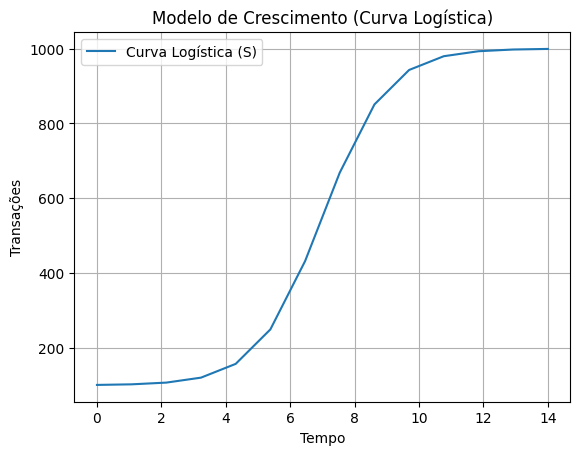

In [66]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

# Dados de exemplo de tempo (t)
A = 14 #D
seconds = A #* 24 * 60 * 60 #(d x h x m x s) <<<<<<<<<<<<<<< precisa descomentar para ter todos os pontos
print(seconds)
t = np.linspace(0, A , seconds)
print(len(t))

# Parâmetros da curva logística
P0 = 100  # Transações inicial
K = 1000  # Valor máximo transações estimado
r =  1 # Taxa de crescimento
t0 = A / 2     # Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística
rate_limit_transacoes_por_segundo = logistic_curve(t, P0, K, r, t0)

# Plotagem da curva logística
plt.plot(t, rate_limit_transacoes_por_segundo, label='Curva Logística (S)')
plt.xlabel('Tempo')
plt.ylabel('Transações')
plt.title('Modelo de Crescimento (Curva Logística)')
plt.legend()
plt.grid(True)
plt.show()


Exemplo de vetorização

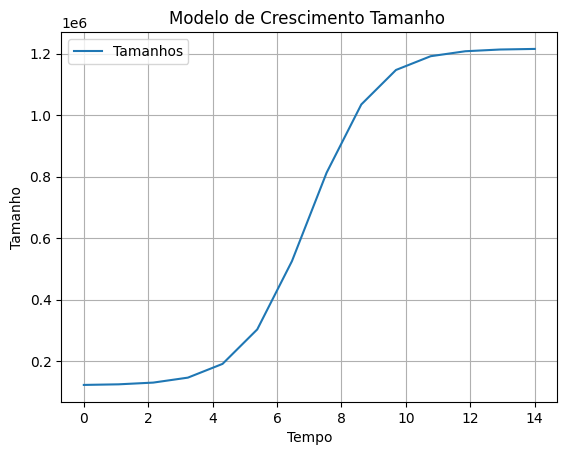

In [67]:
blockchain_predict = predict.blockchain_predict()

 
sum_size_tps = rate_limit_transacoes_por_segundo * blockchain_predict.transaction_size
plt.plot(t, sum_size_tps, label='Tamanhos')
plt.xlabel('Tempo')
plt.ylabel('Tamanho')
plt.title('Modelo de Crescimento Tamanho ')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
#PARALELO 18s
def calculate_cumulative_sum(array):
    return np.cumsum(array)

def cumulative_sum_positions_below_threshold(array, threshold):
    cum_sum = calculate_cumulative_sum(array)
    below_threshold_indices = np.where(cum_sum < threshold)[0]
    return below_threshold_indices

def remove_values_below_threshold(array, positions_below_threshold):
    return np.delete(array, positions_below_threshold)

sum_size_tps_analisys = np.copy(sum_size_tps)
graph_aggregate_transactions_block = np.array([])

messages_transacoes_por_segundo = np.copy(rate_limit_transacoes_por_segundo)

blockchain = np.empty((0, 3), dtype=object) #num_bloco, quant_transações, tempo_decorrido

async def main(sum_size_tps_analisys, messages_transacoes_por_segundo, graph_aggregate_transactions_block, blockchain):
    loop = asyncio.get_running_loop()


    # Criando um executor de processos
    with concurrent.futures.ProcessPoolExecutor() as executor:
        while len(sum_size_tps_analisys) > 0:
            # Executa as duas chamadas de função de forma assíncrona e paralela
            tasks = [
                #procurando transações para formar um bloco (tshoold max tamanho do bloco)
                loop.run_in_executor(executor, cumulative_sum_positions_below_threshold, sum_size_tps_analisys, blockchain_predict.absolute_max_bytes),

                #temos que saber se a quantidade de mensagens permitidos é suficiente
                loop.run_in_executor(executor, cumulative_sum_positions_below_threshold, messages_transacoes_por_segundo, blockchain_predict.max_message_count)
            ]
            # Aguarda as duas chamadas de função serem concluídas
            results = await asyncio.gather(*tasks)
            
            aggregate_transactions_block, total_messages_block = results

            
            #soma dos tamanhos das transações < que deve ser menor que o absolute_max_bytes dado acima
            #cumulative_sum_transactions_size_in_block = await calculate_cumulative_sum(sum_size_tps_analisys[aggregate_transactions_block])[-1]#last element

            #cumulative_sum_messages_in_block = await calculate_cumulative_sum(messages_transacoes_por_segundo[total_messages_block])[-1]#last element

            seconds_if_max_bytes = len(aggregate_transactions_block)
            seconds_if_max_messages = len(total_messages_block)

            remove_transactions = np.empty(0)
            if seconds_if_max_bytes >= blockchain_predict.batch_timeout \
                and seconds_if_max_messages >= blockchain_predict.batch_timeout:
                #codigo para batch timeout
                print("batch timeout") #REVER
                remove_transactions = np.arange(blockchain_predict.batch_timeout)
                

            elif seconds_if_max_bytes <= seconds_if_max_messages: #Caso atingir primeiro o maximo de bytes
                print('max_bytes')
                remove_transactions = np.copy(aggregate_transactions_block)
                

            elif seconds_if_max_bytes > seconds_if_max_messages: #Caso atingir primeiro o maximo de mensagens
                print('max_messages')
                remove_transactions = np.copy(total_messages_block)
                pass



            #print(f'cumulative_sum_messages_in_block {cumulative_sum_messages_in_block}, blockchain_predict.max_message_count {blockchain_predict.max_message_count}')
            #print(f'time bytes {len(aggregate_transactions_block)}s, time messages {len(total_messages_block)}s')

            
            sum_size_tps_analisys           = remove_values_below_threshold(sum_size_tps_analisys, remove_transactions) # Remover transações analisadas do loop
            messages_transacoes_por_segundo = remove_values_below_threshold(messages_transacoes_por_segundo, remove_transactions) # Remover transações analisadas do loop

            
            #print('Time elapsed until new block', len(aggregate_transactions_block))    
            time_elapsed_new_block = len(aggregate_transactions_block) # cada posição é um segundo de transações
            graph_aggregate_transactions_block = np.append(graph_aggregate_transactions_block, time_elapsed_new_block)

#await main(sum_size_tps_analisys, messages_transacoes_por_segundo, graph_aggregate_transactions_block, blockchain)


In [69]:
#ORIGINAL 3s
def cumulative_sum_positions_below_threshold(array, threshold):
    cum_sum = np.cumsum(array)
    below_threshold_indices = np.where(cum_sum < threshold)[0]
    return below_threshold_indices

def remove_values_below_threshold(array, positions_below_threshold):
    return np.delete(array, positions_below_threshold)

sum_size_tps_analisys = np.copy(sum_size_tps)
graph_aggregate_transactions_block = np.array([])

messages_transacoes_por_segundo = np.copy(rate_limit_transacoes_por_segundo)

blockchain = np.empty((0, 3), dtype=object) #num_bloco, quant_transações, tempo_decorrido

while(len(sum_size_tps_analisys) > 0): 

    #procurando transações para formar um bloco (tshoold max tamanho do bloco)
    aggregate_transactions_block = cumulative_sum_positions_below_threshold(sum_size_tps_analisys, blockchain_predict.absolute_max_bytes)
    
    #soma dos tamanhos das transações < que deve ser menor que o absolute_max_bytes dado acima
    cumulative_sum_transactions_size_in_block = np.cumsum(sum_size_tps_analisys[aggregate_transactions_block])[-1]#last element

    #temos que saber se a quantidade de mensagens permitidos é suficiente
    total_messages_block = cumulative_sum_positions_below_threshold(messages_transacoes_por_segundo, blockchain_predict.max_message_count)
    cumulative_sum_messages_in_block = np.cumsum(messages_transacoes_por_segundo[total_messages_block])[-1]#last element

    seconds_if_max_bytes = len(aggregate_transactions_block)
    seconds_if_max_messages = len(total_messages_block)

    remove_transactions = np.empty(0)
    if seconds_if_max_bytes >= blockchain_predict.batch_timeout \
        and seconds_if_max_messages >= blockchain_predict.batch_timeout:
        #codigo para batch timeout
        print("batch timeout") #REVER
        remove_transactions = np.arange(blockchain_predict.batch_timeout)
        

    elif seconds_if_max_bytes <= seconds_if_max_messages: #Caso atingir primeiro o maximo de bytes
        print('max_bytes')
        remove_transactions = np.copy(aggregate_transactions_block)
        

    elif seconds_if_max_bytes > seconds_if_max_messages: #Caso atingir primeiro o maximo de mensagens
        print('max_messages')
        remove_transactions = np.copy(total_messages_block)
        pass



    #print(f'cumulative_sum_messages_in_block {cumulative_sum_messages_in_block}, blockchain_predict.max_message_count {blockchain_predict.max_message_count}')
    #print(f'time bytes {len(aggregate_transactions_block)}s, time messages {len(total_messages_block)}s')

    
    sum_size_tps_analisys           = remove_values_below_threshold(sum_size_tps_analisys, remove_transactions) # Remover transações analisadas do loop
    messages_transacoes_por_segundo = remove_values_below_threshold(messages_transacoes_por_segundo, remove_transactions) # Remover transações analisadas do loop

    
    #print('Time elapsed until new block', len(aggregate_transactions_block))    
    time_elapsed_new_block = len(aggregate_transactions_block) # cada posição é um segundo de transações
    graph_aggregate_transactions_block = np.append(graph_aggregate_transactions_block, time_elapsed_new_block)



max_bytes


In [70]:
print("batch timeout", blockchain_predict.batch_timeout)

batch timeout 300


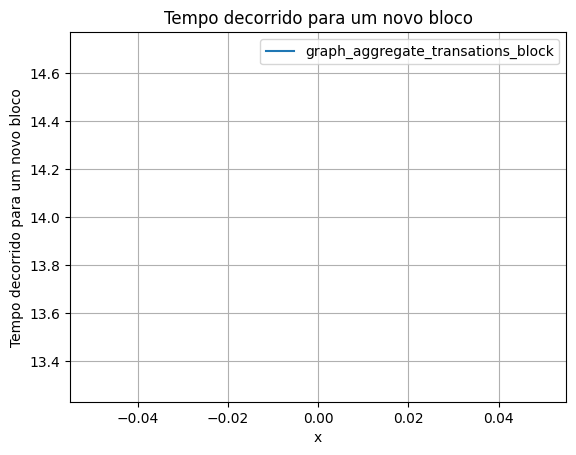

In [71]:
# Plotagem da quantidade de transações agrupadas por bloco
x = np.arange(0, len(graph_aggregate_transactions_block))

plt.plot(x, graph_aggregate_transactions_block, label='graph_aggregate_transactions_block')
plt.xlabel('x')
plt.ylabel('Tempo decorrido para um novo bloco')
plt.title('Tempo decorrido para um novo bloco')
plt.legend()
plt.grid(True)
plt.show()

Parte2

ANOTAÇÕES

In [72]:
import numpy as np

def cumulative_sum_with_flag(array, threshold):
    cum_sum = np.cumsum(array)
    flag = np.zeros_like(cum_sum, dtype=bool)
    flag[cum_sum >= threshold] = True
    cum_sum[flag] = 0
    return cum_sum

# Exemplo de uso
array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
threshold = 10
result = cumulative_sum_with_flag(array, threshold)
print(result)



[1 3 6 0 0 0 0 0 0 0]


In [73]:
import numpy as np

# Função predict
def predict(x):
    return 2 * x + 1

# Vetor de entrada
v = np.array([0, 1, 2, 3, 4])

# Aplicar a função predict a todos os elementos de v de uma vez
resultado = predict(v)

print(resultado)

resultado1 = np.delete(v,v)
print(resultado1)

[1 3 5 7 9]
[]


In [74]:
import numpy as np

# Criando um np.array de objetos
array_de_objetos = np.array([["Alice", 30, "F"],
                             ["Bob", 25, "M"],
                             ["Charlie", 35, "M"]], dtype=object)

# Exibindo o array
print("Array de objetos:")
print(array_de_objetos)

# Acessando elementos do array
print("\nAcessando elementos do array:")
print("Nome:", array_de_objetos[0][0])
print("Idade:", array_de_objetos[0][1])
print("Sexo:", array_de_objetos[0][2])


Array de objetos:
[['Alice' 30 'F']
 ['Bob' 25 'M']
 ['Charlie' 35 'M']]

Acessando elementos do array:
Nome: Alice
Idade: 30
Sexo: F
